In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
!pip install torchinfo
import torchinfo

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
#=======================Define masking function=======================#
class Mask(object):
    def __init__(self, masking_rate):
        self.masking_rate = masking_rate

    def __call__(self, matrix_3d):
        num_columns_to_mask = int(self.masking_rate * matrix_3d.shape[2])
        columns_to_mask = np.random.choice(matrix_3d.shape[2], num_columns_to_mask, replace=False)
        matrix_3d_mask = matrix_3d.clone()
        matrix_3d_mask[:,:, columns_to_mask] = 0
        return matrix_3d, matrix_3d_mask



In [3]:
#=======================Training parameters=======================#
masking_rate = 0.5   # masking rate
bs = 64              # batch size (og:64)
lr = 0.0002          # learning rate (og:0.0002)
n_epoch = 10         # number of epoch

In [4]:
# #=======================Create MNIST datasets=======================#
# ## create two transform (G has masked data and D has original data)
# mask = Mask(masking_rate)
# transform_d_g = transforms.Compose([transforms.ToTensor(),mask])

# train_dataset_d_g = datasets.MNIST(root='./mnist_data/', train=True, transform=transform_d_g, download=True)
# train_loader_d_g = torch.utils.data.DataLoader(dataset=train_dataset_d_g, batch_size=bs, shuffle=True)

# validation_dataset_d_g = datasets.MNIST(root='./mnist_data/', train=False, transform=transform_d_g, download=False)
# validation_loader_d_g = torch.utils.data.DataLoader(dataset=train_dataset_d_g, batch_size=bs, shuffle=False)

# test_dataset_d_g = datasets.MNIST(root='./mnist_data/', train=False, transform=transform_d_g, download=False)
# test_loader_d_g = torch.utils.data.DataLoader(dataset=train_dataset_d_g, batch_size=bs, shuffle=False)

In [5]:
#=======================Create F-MNIST datasets=======================#
## create two transform (G has masked data and D has original data)
mask = Mask(masking_rate)
transform_d_g = transforms.Compose([transforms.ToTensor(),mask])

train_dataset_d_g = datasets.FashionMNIST(root='./F_mnist_data/', train=True, transform=transform_d_g, download=True)
train_loader_d_g = torch.utils.data.DataLoader(dataset=train_dataset_d_g, batch_size=bs, shuffle=True)

validation_dataset_d_g = datasets.FashionMNIST(root='./F_mnist_data/', train=False, transform=transform_d_g, download=False)
validation_loader_d_g = torch.utils.data.DataLoader(dataset=train_dataset_d_g, batch_size=bs, shuffle=False)

test_dataset_d_g = datasets.FashionMNIST(root='./F_mnist_data/', train=False, transform=transform_d_g, download=False)
test_loader_d_g = torch.utils.data.DataLoader(dataset=train_dataset_d_g, batch_size=bs, shuffle=False)


100%|██████████| 26421880/26421880 [00:01<00:00, 14971512.60it/s]


Extracting ./F_mnist_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./F_mnist_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 273581.06it/s]


Extracting ./F_mnist_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./F_mnist_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4995912.56it/s]


Extracting ./F_mnist_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./F_mnist_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22633414.04it/s]

Extracting ./F_mnist_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./F_mnist_data/FashionMNIST/raw



In [6]:
#=======================Build UNET GAN=======================#
# ref: https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3
class UNet(nn.Module):
    def __init__(self, z_dim, generator=True, feature_map=True):
        super().__init__()
        self.generator = generator
        self.feature_map = feature_map

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 1x28x28
        self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1) # output: 64x28x28
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 64x28x28
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 64x14x14

        # input: 64x14x14
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 128x14x14
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 128x14x14
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 128x7x7

        # input: 128x7x7
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 256x7x7
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 256x7x7
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 256x3x3


        # Decoder
        # input: 256x7x7
        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # output: 128x14x14
        self.d11 = nn.Conv2d(256, 128, kernel_size=3, padding=1) # output: 128x14x14
        self.d12 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 128x14x14

        # output: 128x14x14
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # output: 64x28x28
        self.d21 = nn.Conv2d(128, 64, kernel_size=3, padding=1) # output: 64x28x28
        self.d22 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 64x28x28

        # Output layer
        self.outconv_g = nn.Conv2d(64, 1, kernel_size=1) # output: 1x28x28

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256*3*3,1)  # Adjust the input size based on your input dimensions
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))

        # Output layer
        if self.generator:
          # Decoder
          xu1 = self.upconv1(xe32)
          xu11 = torch.cat([xu1, xe22], dim=1)
          xd11 = F.relu(self.d11(xu11))
          xd12 = F.relu(self.d12(xd11))

          xu2 = self.upconv2(xd12)
          xu22 = torch.cat([xu2, xe12], dim=1)
          xd21 = F.relu(self.d21(xu22))
          xd22 = F.relu(self.d22(xd21))
          out = torch.tanh(self.outconv_g(xd22))
          return out

        else:
          xp3 = self.pool3(xe32)
          xe32 = self.flatten(xp3)
          out = torch.sigmoid(self.fc1(xe32))
          return out

In [7]:
#=======================Build the network=======================#
mnist_dim = train_dataset_d_g.data.size(1) * train_dataset_d_g.data.size(2)

G = UNet(mnist_dim, True).to(device)
D = UNet(mnist_dim, False).to(device)

torch.save(G.state_dict(), 'unet_generator_model.pth')

torchinfo.summary(D, input_size=[64,1,28,28])

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [64, 1]                   717,441
├─Conv2d: 1-1                            [64, 64, 28, 28]          640
├─Conv2d: 1-2                            [64, 64, 28, 28]          36,928
├─MaxPool2d: 1-3                         [64, 64, 14, 14]          --
├─Conv2d: 1-4                            [64, 128, 14, 14]         73,856
├─Conv2d: 1-5                            [64, 128, 14, 14]         147,584
├─MaxPool2d: 1-6                         [64, 128, 7, 7]           --
├─Conv2d: 1-7                            [64, 256, 7, 7]           295,168
├─Conv2d: 1-8                            [64, 256, 7, 7]           590,080
├─MaxPool2d: 1-9                         [64, 256, 3, 3]           --
├─Flatten: 1-10                          [64, 2304]                --
├─Linear: 1-11                           [64, 1]                   2,305
Total params: 1,864,002
Trainable params: 1,864,002
N

In [8]:
#=======================Choose loss and optimizer=======================#
# loss
criterion = nn.BCELoss() # binary crossentropy loss, normalised ./. two classes
mse_loss = nn.MSELoss(reduce=True,reduction='sum')

# optimizer
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [9]:
def D_train(x_d,x_g):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    bs = x_d.shape[0]
    x_real, y_real = x_d.view(-1, mnist_dim), torch.ones(bs, 1)  # assigning the input image with 1 (real)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_d)
    D_real_loss = criterion(D_output, y_real)

    # train discriminator on fake
    x_fake, y_fake = G(x_g), Variable(torch.zeros(bs, 1).to(device)) # assigning the input image with 0 (fake)
    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)  # probability compare with 0

    # gradient backprop & optimize ONLY D's parameters
    D_loss = (D_real_loss + D_fake_loss)/2
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()

In [10]:
def G_train(x_d, x_g):
    #=======================Train the generator=======================#
    bs = x_g.shape[0]
    G.zero_grad()

    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(x_g)
    G_output2 = G_output.view(G_output.size(0), 1, 28, 28)
    D_output = D(G_output2)

    G_loss = criterion(D_output, y) + mse_loss(G_output2, x_d)
    m_loss = mse_loss(G_output, x_d)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item(), m_loss.data.item()

100%|█████████▉| 937/938 [02:14<00:00,  7.04it/s]

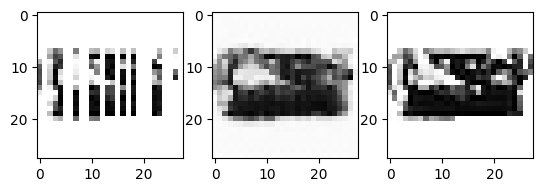

100%|█████████▉| 937/938 [02:15<00:00,  6.93it/s]


[1/10]: loss_d: 0.69266, loss_g: 0.72842, loss_mse: 0.03024


100%|█████████▉| 937/938 [02:10<00:00,  7.27it/s]

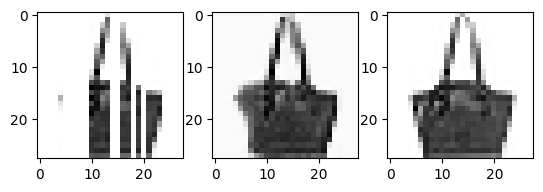

100%|█████████▉| 937/938 [02:10<00:00,  7.18it/s]


[2/10]: loss_d: 0.69310, loss_g: 0.70601, loss_mse: 0.01202


100%|█████████▉| 937/938 [02:10<00:00,  7.18it/s]

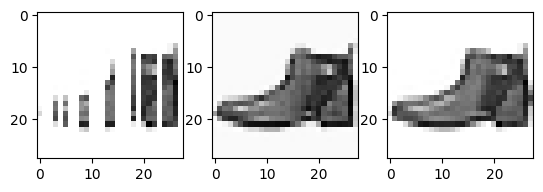

100%|█████████▉| 937/938 [02:10<00:00,  7.17it/s]


[3/10]: loss_d: 0.69305, loss_g: 0.70343, loss_mse: 0.00959


100%|█████████▉| 937/938 [02:10<00:00,  7.16it/s]

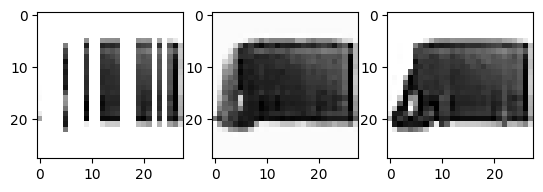

100%|█████████▉| 937/938 [02:10<00:00,  7.16it/s]


[4/10]: loss_d: 0.69304, loss_g: 0.70231, loss_mse: 0.00854


100%|█████████▉| 937/938 [02:10<00:00,  7.06it/s]

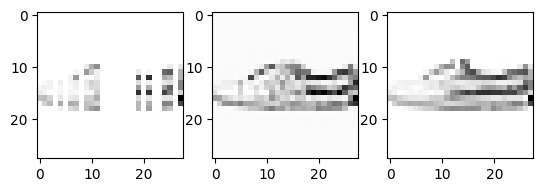

100%|█████████▉| 937/938 [02:10<00:00,  7.18it/s]


[5/10]: loss_d: 0.69308, loss_g: 0.70091, loss_mse: 0.00772


100%|█████████▉| 937/938 [02:10<00:00,  7.24it/s]

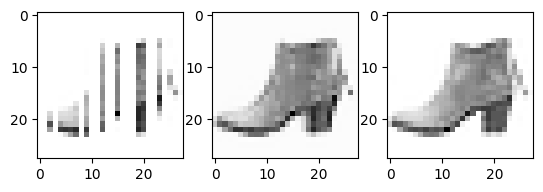

100%|█████████▉| 937/938 [02:10<00:00,  7.16it/s]


[6/10]: loss_d: 0.69304, loss_g: 0.70133, loss_mse: 0.00742


100%|█████████▉| 937/938 [02:09<00:00,  7.27it/s]

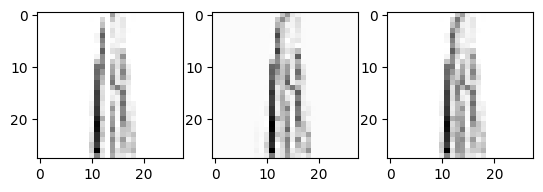

100%|█████████▉| 937/938 [02:10<00:00,  7.18it/s]


[7/10]: loss_d: 0.69299, loss_g: 0.70011, loss_mse: 0.00675


100%|█████████▉| 937/938 [02:10<00:00,  7.26it/s]

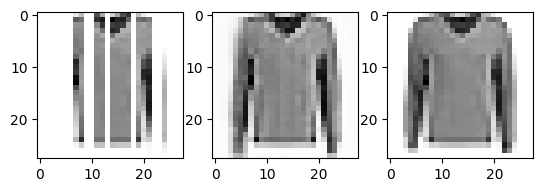

100%|█████████▉| 937/938 [02:10<00:00,  7.18it/s]


[8/10]: loss_d: 0.69367, loss_g: 0.70189, loss_mse: 0.00691


100%|█████████▉| 937/938 [02:10<00:00,  7.26it/s]

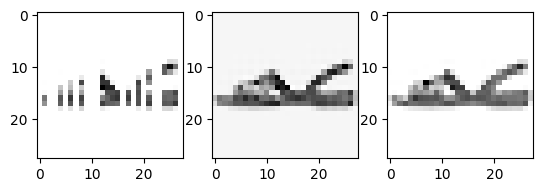

100%|█████████▉| 937/938 [02:10<00:00,  7.16it/s]


[9/10]: loss_d: 0.69315, loss_g: 0.69945, loss_mse: 0.00619


100%|█████████▉| 937/938 [02:10<00:00,  6.99it/s]

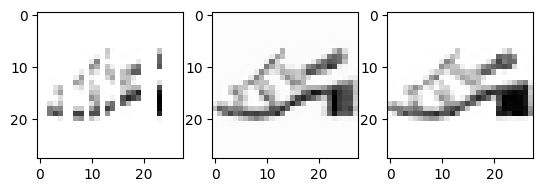

100%|█████████▉| 937/938 [02:10<00:00,  7.18it/s]

[10/10]: loss_d: 0.69315, loss_g: 0.69958, loss_mse: 0.00605


In [11]:
#===================Train the model===================#
for epoch in range(1, n_epoch+1):
    D_losses,G_losses, mse_losses = [],[],[]

    for batch_idx,(((x_d, x_g), _)) in enumerate(tqdm(train_loader_d_g)):
        x_d=x_d.to(device)
        x_g=x_g.to(device)
        G_losses.append(G_train(x_d, x_g)[0])
        D_losses.append(D_train(x_d, x_g))
        mse_losses.append(G_train(x_d, x_g)[1])

        # plot data
        if batch_idx == len(train_loader_d_g)-1:
            data = x_g[0][0]
            original = x_d[0][0]

            fig, ax = plt.subplots(1,3)
            ax[0].imshow(transforms.ToPILImage()(data), cmap='Greys')
            ax[1].imshow(G(x_g).cpu().detach().numpy()[0].reshape(28,28), cmap='Greys')
            ax[2].imshow(transforms.ToPILImage()(original), cmap='Greys')
            plt.show()
            break

    print('[%d/%d]: loss_d: %.5f, loss_g: %.5f, loss_mse: %.5f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses)), torch.mean(torch.FloatTensor(mse_losses))))


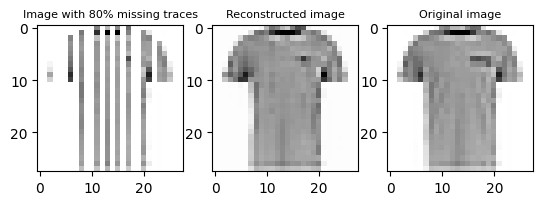

In [12]:
#===================Test the model===================#
index = 7

for batch_idx,(((x_d, x_g), _)) in enumerate(validation_loader_d_g):
    x_d=x_d.to(device)
    x_g=x_g.to(device)
    if batch_idx == index:
        data = x_g[0][0]
        original = x_d[0][0]

        fig, ax = plt.subplots(1,3)
        ax[0].imshow(transforms.ToPILImage()(data), cmap='Greys')
        ax[0].set_title(f'Image with 80% missing traces',size=8)
        ax[1].imshow(G(x_g).cpu().detach().numpy()[0].reshape(28,28), cmap='Greys')
        ax[1].set_title(f'Reconstructed image',size=8)
        ax[2].imshow(transforms.ToPILImage()(original), cmap='Greys')
        ax[2].set_title(f'Original image',size=8)
        plt.show()

        break


In [13]:
torchinfo.summary(G, input_size=[64,1,28,28])

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [64, 1, 28, 28]           2,305
├─Conv2d: 1-1                            [64, 64, 28, 28]          640
├─Conv2d: 1-2                            [64, 64, 28, 28]          36,928
├─MaxPool2d: 1-3                         [64, 64, 14, 14]          --
├─Conv2d: 1-4                            [64, 128, 14, 14]         73,856
├─Conv2d: 1-5                            [64, 128, 14, 14]         147,584
├─MaxPool2d: 1-6                         [64, 128, 7, 7]           --
├─Conv2d: 1-7                            [64, 256, 7, 7]           295,168
├─Conv2d: 1-8                            [64, 256, 7, 7]           590,080
├─ConvTranspose2d: 1-9                   [64, 128, 14, 14]         131,200
├─Conv2d: 1-10                           [64, 128, 14, 14]         295,040
├─Conv2d: 1-11                           [64, 128, 14, 14]         147,584
├─ConvTranspose2d: 1-12                  [6

Total convolution layers: 11
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 128, 14, 14]) torch.Size([64, 128, 14, 14])


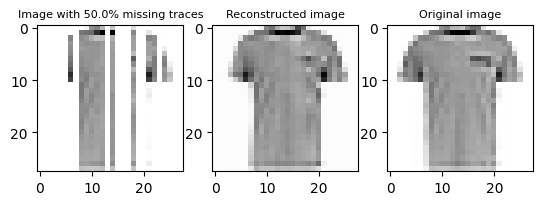

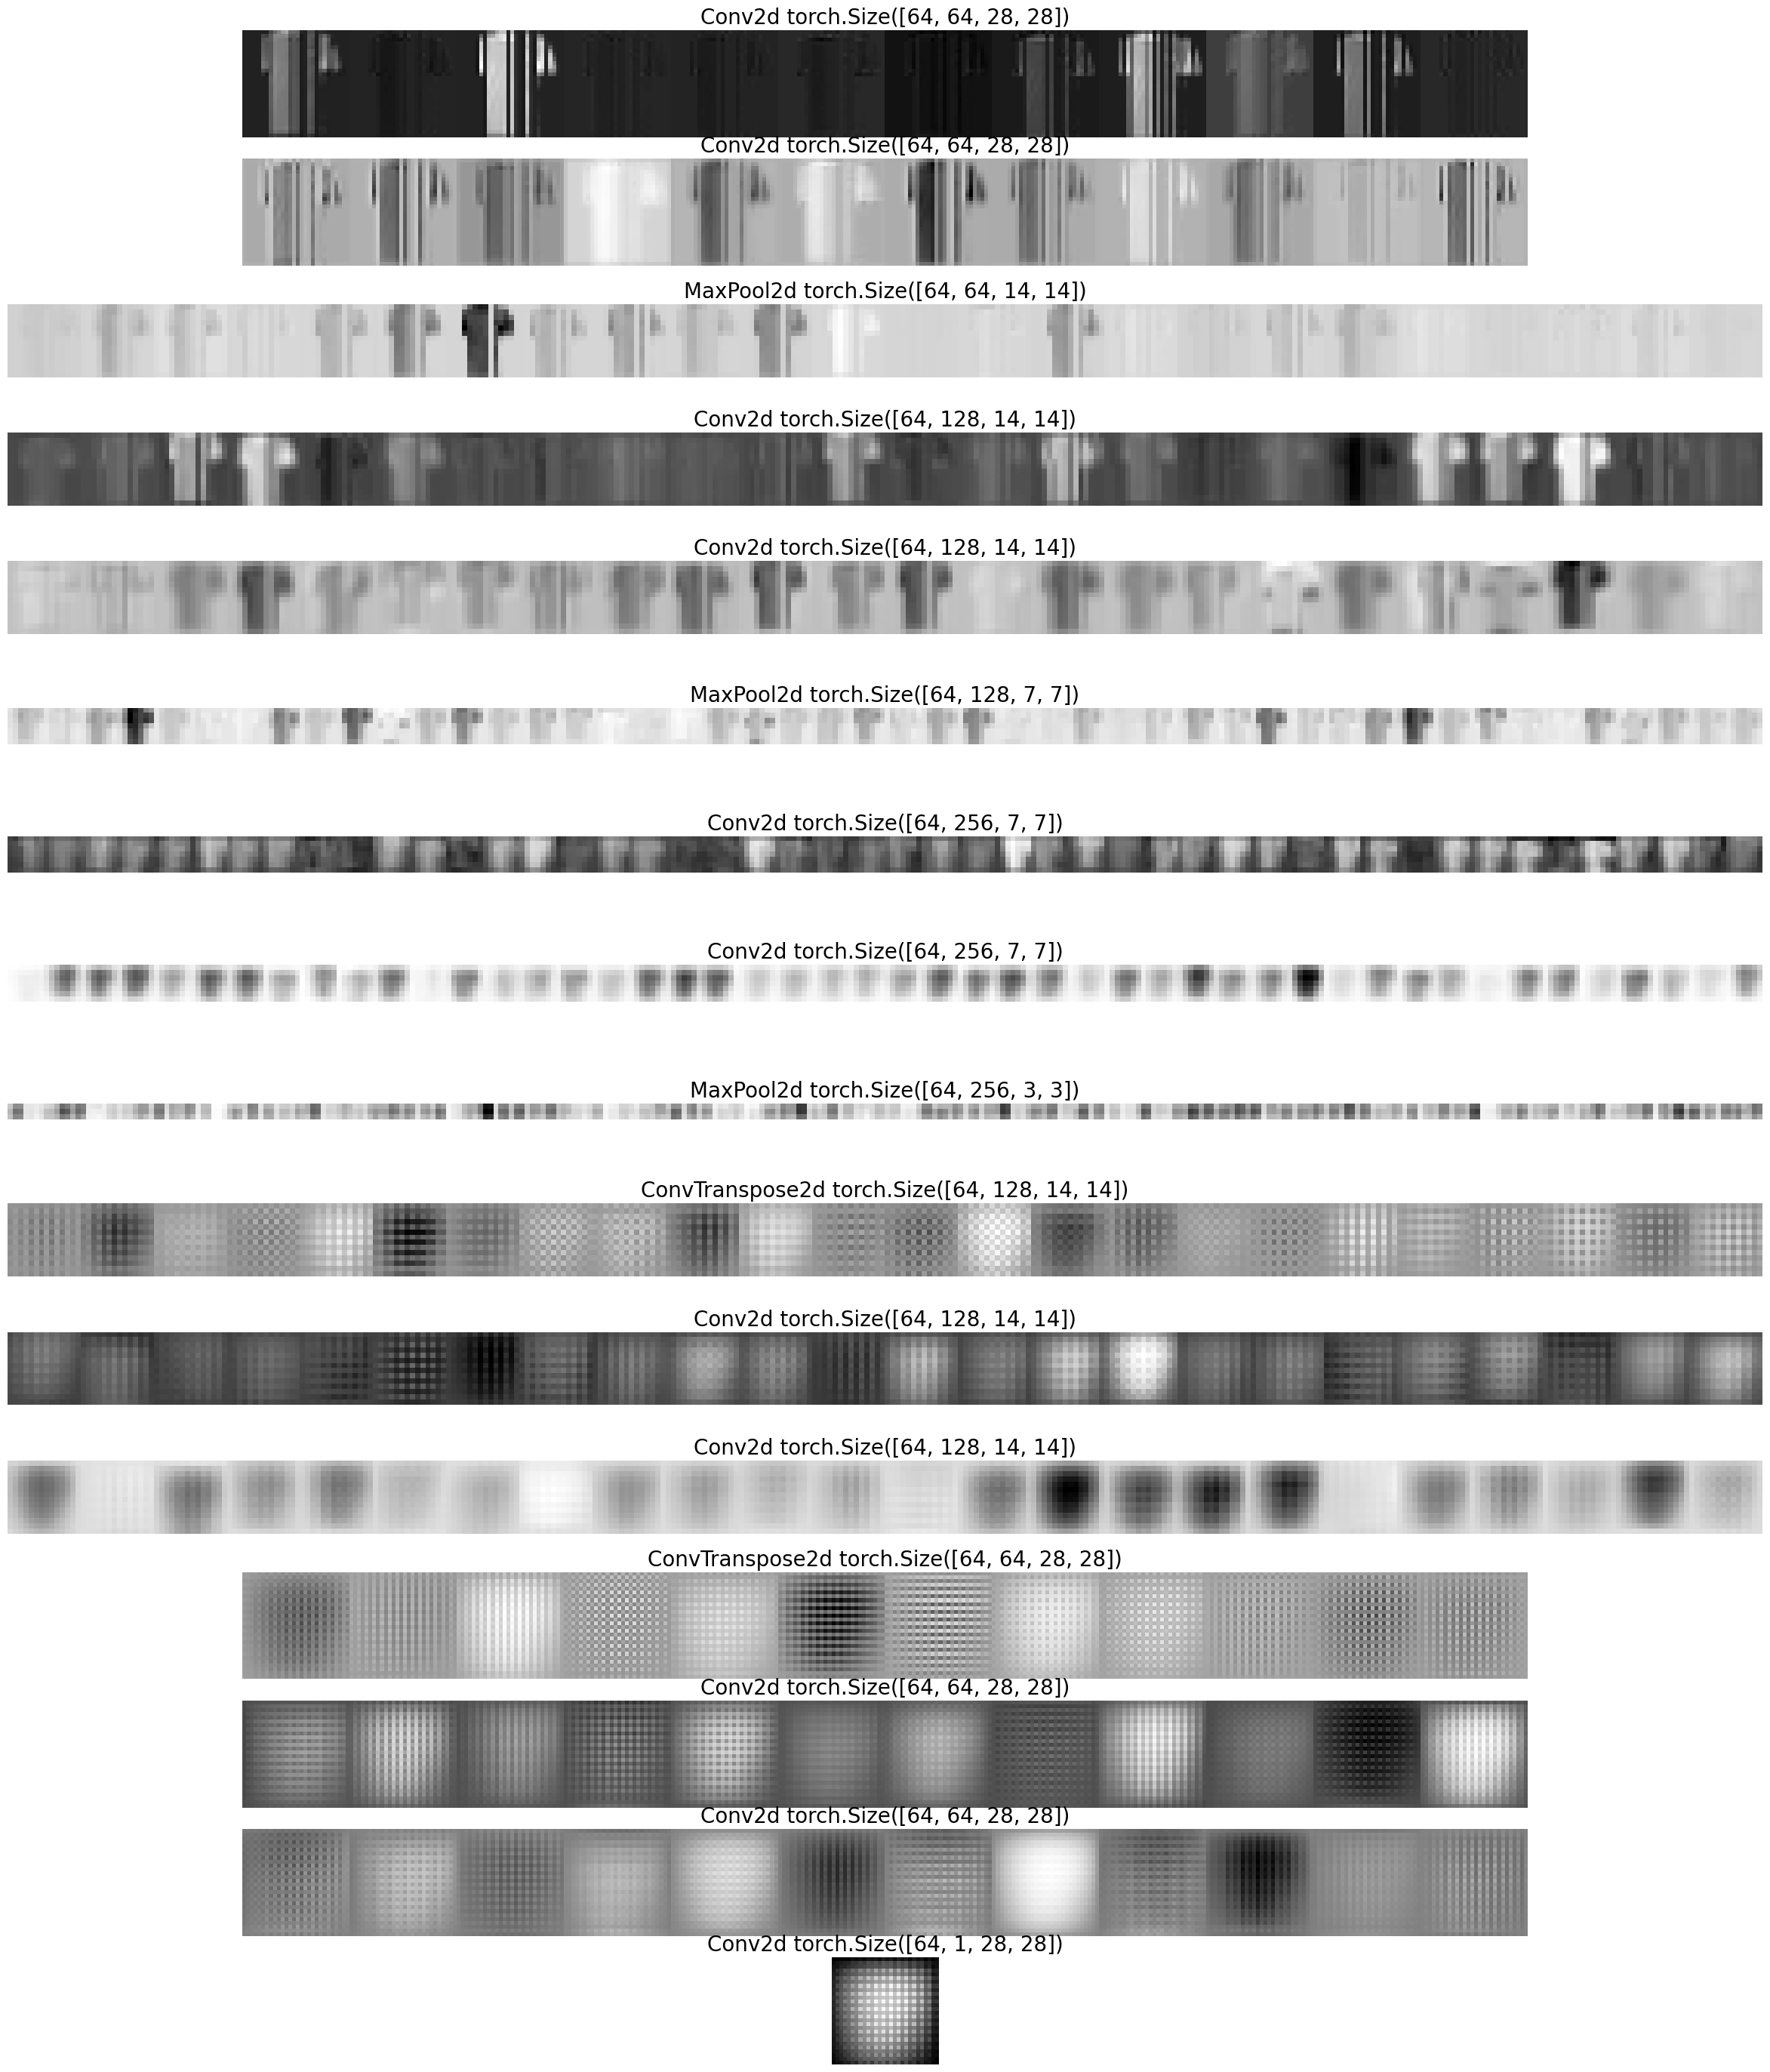

In [14]:
#===================Visualise the feature map===================#
## ref: https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573
## ref: https://www.analyticsvidhya.com/blog/2020/11/tutorial-how-to-visualize-feature-maps-directly-from-cnn-layers/
import random
index = 7
model_weights =[]
conv_layers = []
model_children = list(G.children())
counter = 0   # count of the conv layers

# append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
print(f"Total convolution layers: {counter}")

for batch_idx,(((x_d, x_g), _)) in enumerate(validation_loader_d_g):
    x_d=x_d.to(device)
    x_g=x_g.to(device)
    print(x_g.shape)

    if batch_idx == index:
        data = x_g[0][0]
        original = x_d[0][0]

        fig, ax = plt.subplots(1,3)
        ax[0].imshow(transforms.ToPILImage()(data), cmap='Greys')
        ax[0].set_title(f'Image with {masking_rate*100}% missing traces',size=8)
        ax[1].imshow(G(x_g).cpu().detach().numpy()[0].reshape(28,28), cmap='Greys')
        ax[1].set_title(f'Reconstructed image',size=8)
        ax[2].imshow(transforms.ToPILImage()(original), cmap='Greys')
        ax[2].set_title(f'Original image',size=8)

        fig = plt.figure(figsize=(30, 35))
        image = x_g
        tensor_dict = {}
        layer = 0
        for count,layer in enumerate(model_children[:16]):
            name = str(layer)
            name = name.split("(")[0]

            if count == 9:
                image = layer(tensor_dict[7])

            elif count == 10:
                print(tensor_dict[9].shape,tensor_dict[4].shape)
                a = torch.cat([tensor_dict[9],tensor_dict[4]], dim=1)
                image = layer(a)

            elif count == 13:
                b = torch.cat([tensor_dict[12],tensor_dict[1]], dim=1)
                image = layer(b)

            else:
                image = layer(image)

            # save the output tensor of each layer
            tensor_dict[count] = image

            # plotting params
            channel = image.shape[1]
            size = image.shape[2]
            elem_per_row = 12
            target_width = elem_per_row * 28

            a = fig.add_subplot(16, 1, count+1)

            images = []
            used = set()
            for i in range(min(target_width // size , channel)):
                new_ind = random.randint(0, channel - 1)
                while new_ind in used:
                    new_ind = random.randint(0, channel - 1)
                used.add(new_ind)
                images.append(image[0][new_ind].reshape(size,size))

            # create image belt
            combined_image = torch.hstack(images)

            imgplot = plt.imshow(combined_image.cpu().detach().numpy(), cmap='Greys')
            imgplot = plt.axis('off')
            a.set_title(f'{name} {image.shape}', fontsize=20)

        break

Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([64, 128, 14, 14]) torch.Size([64, 128, 14, 14])
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), paddi

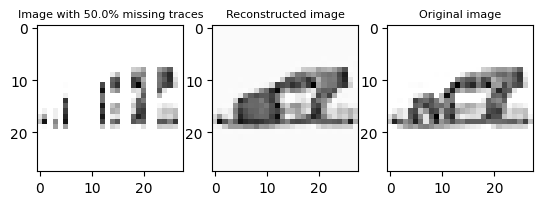

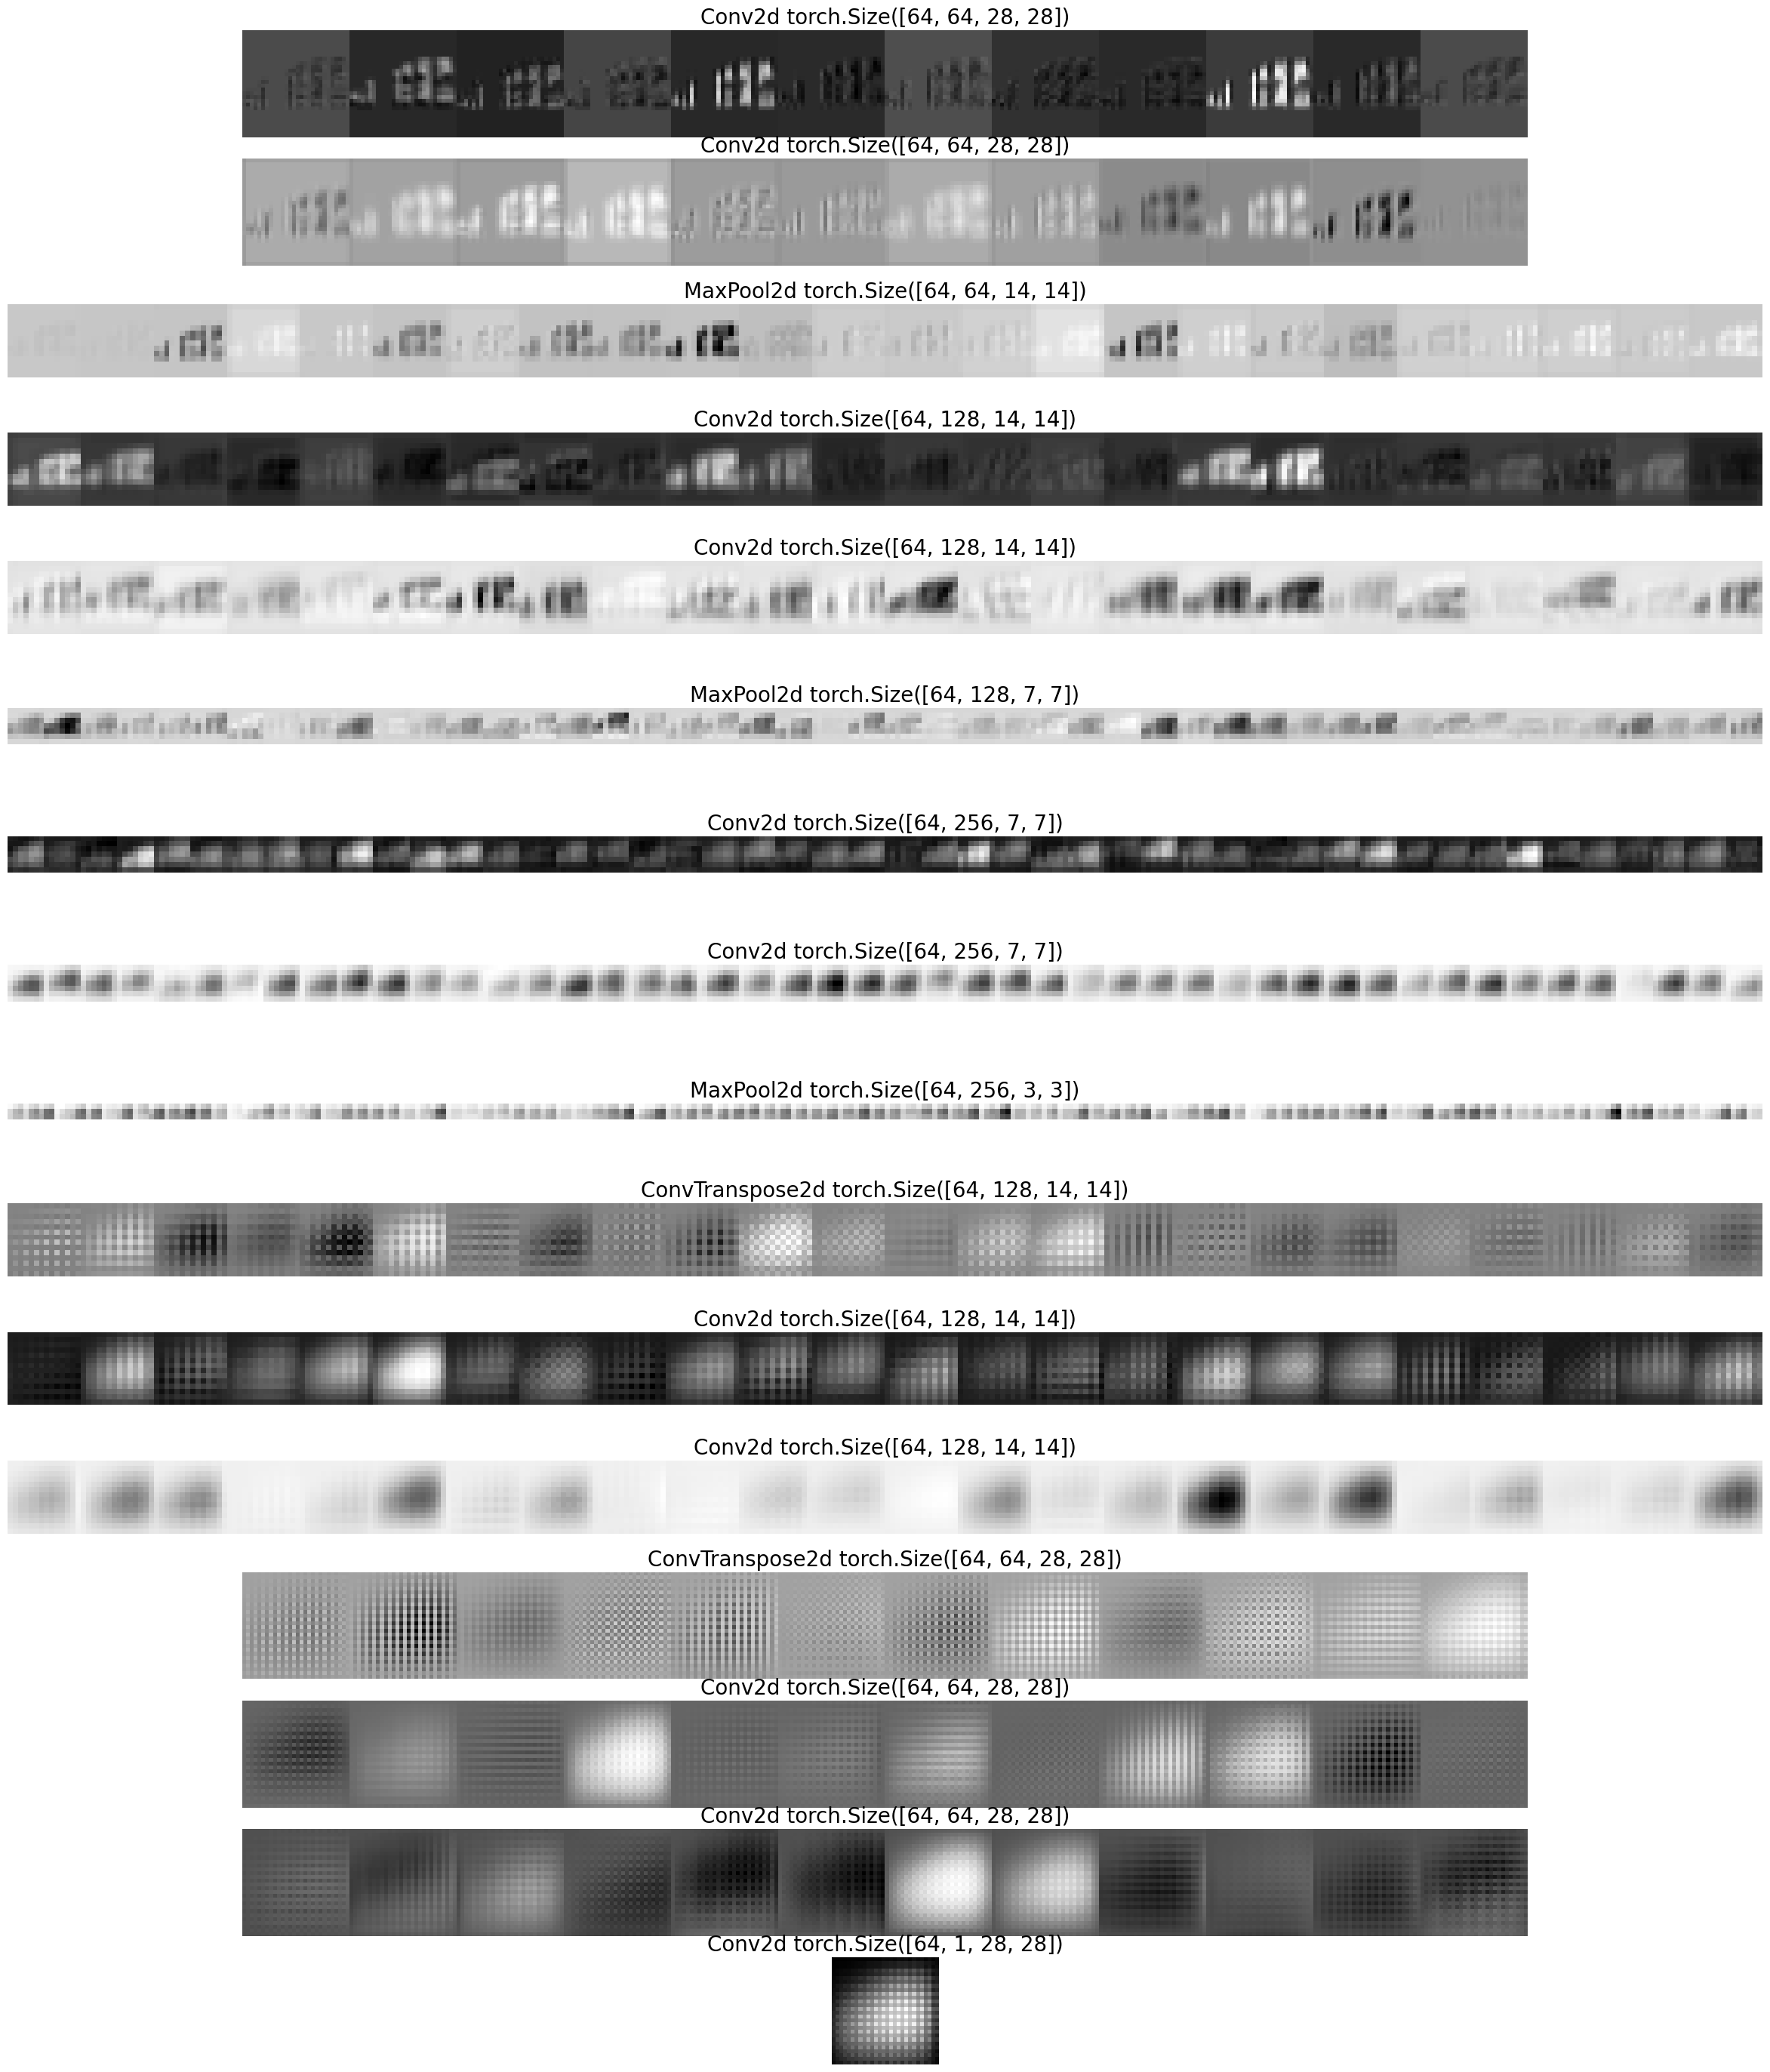

In [21]:
fig, ax = plt.subplots(1,3)
expanded_tensor = data.unsqueeze(0).expand(64, -1, -1)
expanded_tensor = expanded_tensor.unsqueeze(1).to(device)
ax[0].imshow(transforms.ToPILImage()(data), cmap='Greys')
ax[0].set_title(f'Image with {masking_rate*100}% missing traces',size=8)
ax[1].imshow(G(expanded_tensor).cpu().detach().numpy()[0].reshape(28,28), cmap='Greys')
ax[1].set_title(f'Reconstructed image',size=8)
ax[2].imshow(transforms.ToPILImage()(original), cmap='Greys')
ax[2].set_title(f'Original image',size=8)

fig = plt.figure(figsize=(30, 35))
image = expanded_tensor
tensor_dict = {}
layer = 0
for count,layer in enumerate(model_children[:16]):
    print(layer)
    name = str(layer)
    name = name.split("(")[0]

    if count == 9:
        image = layer(tensor_dict[7])

    elif count == 10:
        print(tensor_dict[9].shape,tensor_dict[4].shape)
        a = torch.cat([tensor_dict[9],tensor_dict[4]], dim=1)
        image = layer(a)

    elif count == 13:
        b = torch.cat([tensor_dict[12],tensor_dict[1]], dim=1)
        image = layer(b)

    else:
        image = layer(image)

    # save the output tensor of each layer
    tensor_dict[count] = image

    # plotting params
    channel = image.shape[1]
    size = image.shape[2]
    elem_per_row = 12
    target_width = elem_per_row * 28

    a = fig.add_subplot(16, 1, count+1)

    images = []
    used = set()
    for i in range(min(target_width // size , channel)):
        new_ind = random.randint(0, channel - 1)
        while new_ind in used:
            new_ind = random.randint(0, channel - 1)
        used.add(new_ind)
        images.append(image[0][new_ind].reshape(size,size))

    # create image belt
    combined_image = torch.hstack(images)

    imgplot = plt.imshow(combined_image.cpu().detach().numpy(), cmap='Greys')
    imgplot = plt.axis('off')
    a.set_title(f'{name} {image.shape}', fontsize=20)